In [1]:
import meep as mp
from meep import mpb
import numpy as np
from matplotlib import pyplot as plt

# Then the wavelength
omega = 1 / 0.785
material_SiN = mp.Medium(index=1.96)
material_SiO2 = mp.Medium(index=1.45)
width_guide = 5
height_guide = 0.2

/home/suda/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/suda/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/suda/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/suda/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
resolution = 200
size_cal_y = 2
size_cal_z = 2

geometry = [
    mp.Block(
        material=material_SiN,
        size=mp.Vector3(mp.inf, width_guide, height_guide),
        center=mp.Vector3(0, 0, height_guide / 2),
    )
]
geometry_lattice = mp.Lattice(size=mp.Vector3(0, size_cal_y, size_cal_z))

In [3]:
num_modes = 4

ms = mpb.ModeSolver(
    geometry_lattice=geometry_lattice,
    geometry=geometry,
    resolution=resolution,
    num_bands=num_modes,
    default_material=material_SiO2,
)

In [4]:
E = []
store_fields = lambda ms_temp, mode: E.append(ms_temp.get_efield(which_band=mode,bloch_phase=False))

In [5]:
k = ms.find_k(
    mp.NO_PARITY,
    omega, # omega
    1, # band_min
    num_modes, # band_max
    mp.Vector3(1,0,0), # korig_and_kdir
    1e-4, # tol
    omega * 2, # kmag_guess
    omega * 0.1, # kmag_min
    omega * 2, # kmag_max
    store_fields, # band_funcs
)
neff=k[0]/omega # 有效折射率
eps = ms.get_epsilon() # 折射率分布
eps_arr=np.transpose(np.array(eps))

Initializing eigensolver data
Computing 4 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 1 x 400 x 400.
Solving for 4 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 2, 0)
     (0, 0, 2)
Cell volume = 4
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.5, -0)
     (0, -0, 0.5)
Geometric objects:
     block, center = (0,0,0.1)
          size (1e+20,5,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 3 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...
1 k-points
  Vector3<2.5477707006369426, 0.0, 0.0>
elapsed time for initialization: 0.11654925346374512
solve_kpoint (2.54777,0,0):
freqs:, k index, k1, k2, k3, kmag/2pi, band 1, band 2, band 3, band 4
Solving for bands 1 to 4...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration   

Current band: 1
Current band: 2
Current band: 3
Current band: 4


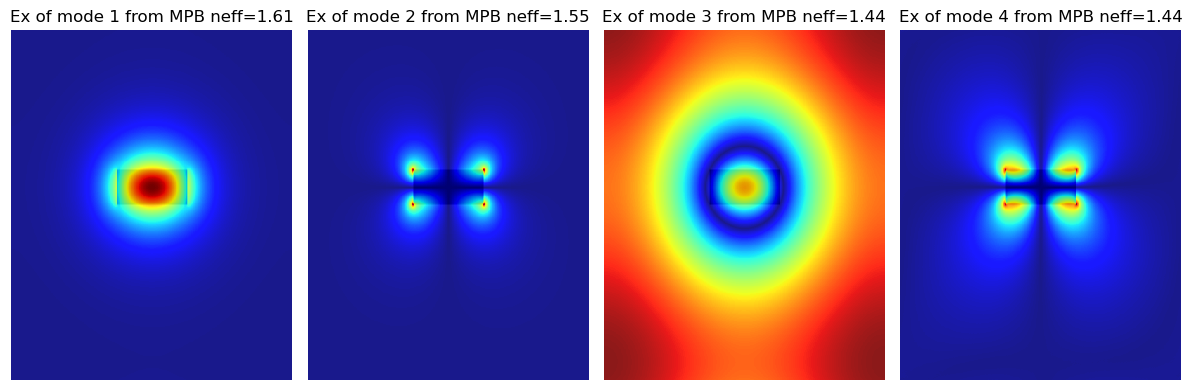

In [9]:
# %%
x_list = np.linspace(-size_cal_y / 2, size_cal_y / 2, resolution * 2)
y_list = np.linspace(-size_cal_z / 2, size_cal_z / 2, resolution * 2)
x_grid, y_grid = np.meshgrid(x_list, y_list)

plt.figure(figsize=(12, 4))
# Plot the E fields
for mode in range(num_modes):
    Ex = np.squeeze(E[mode][:, :, 0, 1]).transpose()
    print("Current band: {}".format(mode + 1))
    plt.subplot(1, num_modes, 1 + mode)
    plt.pcolormesh(x_grid, y_grid, eps.transpose(), cmap="binary")
    plt.pcolormesh(x_grid, y_grid, np.abs(Ex), cmap="jet", alpha=0.9)
    plt.axis("off")
    st_title = (
        "Ex of mode "
        + str(mode + 1)
        + " from MPB neff="
        + str("%.2f" % (k[mode] / omega))
    )
    plt.title(st_title)
plt.tight_layout()
# plt.savefig('SimulatedFieldMPB.png')
plt.show()